# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

# Import Libraries and Initialize h2o Cluster

In [2]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 35 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_navdeep_vcnglh
H2O cluster total nodes:,1
H2O cluster free memory:,27.27 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


# Import Processed Simulated Train and Test Datasets

In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'train_simulated_processed.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'test_simulated_processed.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (80000, 24)
Test shape: (20000, 24)


In [5]:
train.head()

Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std
51965,1,1,1,1,1,-2.72091,-0.0685853,0.128834,0.19742,1,0,0,0,0,0,0,1,0,1.17751,1.09196,-0.924302,-1.48332,-0.339844
17435,1,1,1,0,2,-2.72091,1.9267,2.82408,0.897373,1,1,0,1,0,0,0,1,0,0.0889578,1.10989,0.0427566,1.59319,0.427192
48424,1,1,1,1,4,-2.72091,0.0715976,0.498041,0.426443,1,1,0,0,0,0,0,1,0,-0.483886,0.886531,0.26511,0.114252,-1.58239
33915,1,1,1,1,1,-2.72091,-0.951668,1.40493,2.3566,1,0,0,0,0,0,0,1,0,-0.937656,0.584315,1.19397,-1.41085,-1.61499
99940,1,0,1,1,2,-2.72091,-0.370235,-0.453614,-0.0833795,0,0,0,0,0,0,1,0,0,0.605907,0.00484684,-0.263273,-1.18119,0.214368
13760,1,1,1,1,4,-2.72091,-0.0891082,1.99819,2.0873,1,0,0,0,0,0,0,1,0,0.32925,-0.0504794,-0.160296,-0.424763,-1.23811
87850,0,1,0,0,1,-2.72091,-0.545174,-1.04493,-0.499752,0,0,1,1,0,0,1,0,0,0.19143,-1.24125,0.488029,1.6645,-0.190901
80162,1,1,1,1,5,-2.72091,-0.983626,-1.69434,-0.710717,0,0,0,0,1,0,0,0,0,-0.993564,0.462289,0.360523,-0.480352,-0.873814
58687,1,1,1,1,5,-2.72091,-0.400844,-0.638193,-0.237349,0,0,0,0,0,0,0,1,0,-0.456458,0.936224,-1.04464,-1.3345,-1.65587
44248,1,1,1,1,3,-2.72091,0.55672,0.562806,0.0060862,1,1,0,0,0,0,1,0,0,0.0178311,0.970295,-0.76748,-0.317553,1.64319


In [6]:
train.summary()

,Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std
type,int,int,int,int,int,int,real,real,real,real,int,int,int,int,int,int,int,int,int,real,real,real,real,real
mins,0.0,0.0,0.0,0.0,0.0,1.0,-2.720908013105422,-3.0820782295520894,-7.12822858651175,-6.9770005928218035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.7335086712513013,-1.733848987912218,-1.7334428338275985,-1.730171248184714,-1.732116338318261
mean,49959.91805,0.5013875,0.8005,0.8508,0.506725,3.001875,-2.720908013105422,0.0007982856251728503,0.00016698464858406678,-0.0006313009765887859,0.49935,0.5009,0.1492,0.493275,0.1996125,0.1510875,0.24965,0.37349999999999994,0.02615,-1.4246381851990008e-16,7.318590178329032e-17,-7.460698725481052e-17,-7.638334409421076e-17,3.069655640786095e-16
maxs,99999.0,1.0,1.0,1.0,1.0,5.0,-2.720908013105422,3.28883722640734,5.9045599258911645,6.470597632146622,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.7350294169553202,1.7302585667902366,1.7353002481840196,1.7321632118093662,1.7298549806351473
sigma,28895.068624157895,0.5000011998573086,0.39962700893686903,0.35628773029931093,0.49995789707607946,1.4162879501603733,3.981301008718052e-16,0.9119039514730629,1.2845097123335294,0.9080878617558317,0.500002702526478,0.5000023150235785,0.35628773029931093,0.49995789707607946,0.3997115797179099,0.3581363854938963,0.432813145699433,0.4837361626015132,0.15958225412368973,1.0000062500585942,1.0000062500585942,1.0000062500585944,1.0000062500585944,1.0000062500585944
zeros,1,39889,15960,11936,39462,0,0,0,0,0,40052,39928,68064,40538,64031,67913,60028,50120,77908,0,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,51965.0,1.0,1.0,1.0,1.0,1.0,-2.720908013105422,-0.06858534100749303,0.1288343483860309,0.19741968939352392,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.1775115799880125,1.0919564613049315,-0.924302351484264,-1.4833240546793658,-0.33984408898839347
1,17435.0,1.0,1.0,1.0,0.0,2.0,-2.720908013105422,1.926704951999059,2.8240784352569843,0.8973734832579258,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.08895778580015472,1.1098892013234662,0.0427566215550848,1.593185960230857,0.4271921652799626
2,48424.0,1.0,1.0,1.0,1.0,4.0,-2.720908013105422,0.07159755219096109,0.4980407747077779,0.4264432225168168,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.4838864321658736,0.8865311234928155,0.26510969515539007,0.11425218963996978,-1.5823924344618083


In [7]:
test.head()

Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std
81101,0,1,1,0,nan,-2.72091,-0.691063,-0.659016,0.0320475,0,0,0,1,0,0,1,0,0,1.21448,-0.757816,1.33938,-0.845874,-0.496708
23267,1,1,1,1,nan,-2.72091,-1.43746,-3.22771,-1.79025,0,0,0,0,0,0,0,1,0,-1.42537,1.15206,0.442023,-1.55794,0.0280184
55847,1,0,1,0,nan,-2.72091,-0.924411,2.00328,2.92769,1,0,0,1,0,0,1,0,0,-1.29557,-0.168411,0.808708,0.0699283,-0.059327
36104,1,0,1,1,nan,-2.72091,-0.109132,0.032153,0.141285,1,0,0,0,0,0,0,1,0,-1.24821,1.58507,-1.62519,-1.23614,-1.1097
13217,1,1,1,1,nan,-2.72091,-1.61251,-1.61564,-0.00312947,0,0,0,0,0,0,0,1,0,-1.67705,1.64615,-1.46395,-1.67884,-1.33186
62817,1,1,1,1,nan,-2.72091,-1.17269,-1.51683,-0.344136,0,0,0,0,0,0,0,1,0,-1.66449,1.41454,1.20835,-1.32205,0.221199
69779,1,1,1,1,nan,-2.72091,0.645227,1.24499,0.599765,1,1,0,0,1,0,0,0,0,-0.544145,0.0486811,-0.758301,0.541987,1.41595
67094,0,1,1,1,nan,-2.72091,-1.13228,-0.827003,0.305278,0,0,0,0,0,0,1,0,0,1.25915,-0.84733,1.06546,-0.612547,-1.42888
53829,0,0,1,0,nan,-2.72091,-0.286394,-2.77156,-2.48516,0,0,0,1,0,0,1,0,0,0.0807618,-0.419714,-1.01388,0.410965,-1.08188
20294,1,1,1,1,nan,-2.72091,-0.318272,0.849848,1.16812,1,0,0,0,0,0,0,1,0,-1.19466,0.701548,-1.0157,0.298431,-1.50917


In [8]:
test.summary()

,Unnamed: 0,binary1,binary2,ctrl_class1,ctrl_class2,fold,intercept,latent_no_noise,latent_with_noise,logistic_noise,outcome,outcome_no_noise,prot_class1,prot_class2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std
type,int,int,int,int,int,int,real,real,real,real,int,int,int,int,int,int,int,int,int,real,real,real,real,real
mins,2.0,0.0,0.0,0.0,0.0,NaN,-2.720908013105422,-2.9708160865975466,-8.181295809324679,-6.102900930067954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.7335108884683608,-1.7338537782198882,-1.733441376184521,-1.7301329627036222,-1.7321569660775795
mean,50157.8278,0.49735,0.8008,0.84715,0.5042,0.0,-2.720908013105422,-0.0031931425006521885,-0.0006679385942969972,0.002525203906355181,0.49935,0.49865,0.15285,0.4958,0.20005,0.1486,0.25695,0.37015,0.02425,0.005793416168055634,-0.010040281554601327,0.007016482839404682,0.007005141663205136,-0.008740306827664591
maxs,99977.0,1.0,1.0,1.0,1.0,NaN,-2.720908013105422,3.1480336616634506,6.735894876511169,5.15068621320296,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.7350832669214469,1.7302742727520708,1.7352094540100085,1.731946069608202,1.729854619799995
sigma,28757.92874371046,0.500005477743883,0.39940873346337624,0.35985184752562877,0.4999948597165646,-0.0,3.617590912196017e-16,0.924023667273663,1.29195133858809,0.9078968103490572,0.5000120779580282,0.5000106779198837,0.35985184752562877,0.49999485971656465,0.4000474964300739,0.35570263735079466,0.43696252048913253,0.48285674379856347,0.15382821800967728,1.0055426115309924,1.0000372671813111,1.0070102272598327,1.0033512857900369,0.9995964206043482
zeros,0,10053,3984,3057,9916,0,0,0,0,0,10013,10027,16943,10084,15999,17028,14861,12597,19515,0,0,0,0,0
missing,0,0,0,0,0,20000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,81101.0,0.0,1.0,1.0,0.0,nan,-2.720908013105422,-0.6910631454449327,-0.6590156737844618,0.032047471660470984,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.2144781109546314,-0.757815933708559,1.339376313521845,-0.8458740554574753,-0.4967081495158298
1,23267.0,1.0,1.0,1.0,1.0,nan,-2.720908013105422,-1.4374551476933446,-3.2277093881615766,-1.790254240468232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.4253650870131225,1.152062459330625,0.4420230703555852,-1.5579391098393272,0.02801836435423993
2,55847.0,1.0,0.0,1.0,0.0,nan,-2.720908013105422,-0.9244111076188346,2.003282213031546,2.927693320650381,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.295574029405828,-0.1684109632559059,0.8087084394405603,0.06992826533325575,-0.05932700022005463


#Setup Predictors, Response, and Fold Column for Modelling Purposes

In [16]:
# Inputs and output
X = ['binary1',
'binary2',
'cat1_0',
'cat1_1',
'cat1_2',
'cat1_3',
'cat1_4',
'fried1_std',
'fried2_std',
'fried3_std',
'fried4_std',
'fried5_std']
fold_column = 'fold'
Y = "outcome"

# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [18]:
# Distribution of outcome in train
train[Y].table()

outcome,Count
0,40052
1,39948


In [19]:
# Distribution of outcome in test
test[Y].table()

outcome,Count
0,10013
1,9987


In [20]:
# Function to get Shapley contributions
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

# Make monotonicity constraints dictionary, which is based on heuristics known about the dataset:
## `f1` will be positively constrained to the outcome
## `f2` will be positively constrained to the outcome
## `f4` will be positively constrained to the outcome
## `f5` will be positively constrained to the outcome
## `b1` will be positively constrained to the outcome
## `b2` will be negatively constrained to the outcome

In [22]:
# Make monotonicity constraints dictionary, which is based on data generation script:
# f1: +
# f2: +
# f3: n/a
# f4: +
# f5: +
# b1: +
# b2: -
# c1: n/a
constraint = 1
mono_constraints = {feature:constraint for feature in X}
del mono_constraints['fried3_std']
del mono_constraints['cat1_0']
del mono_constraints['cat1_1']
del mono_constraints['cat1_2']
del mono_constraints['cat1_3']
del mono_constraints['cat1_4']
mono_constraints['binary2'] = -1
mono_constraints

{'binary1': 1,
 'binary2': -1,
 'fried1_std': 1,
 'fried2_std': 1,
 'fried4_std': 1,
 'fried5_std': 1}

# Build Default GBM with Monotonic Constraints

In [23]:
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Model Summary

In [24]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575925687897_19915


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,18595.0,5.0,5.0,5.0,16.0,32.0,24.92




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.16847027337478707
RMSE: 0.4104513045110066
LogLoss: 0.5107082541517186
Mean Per-Class Error: 0.24249117606008763
AUC: 0.8393628194606648
pr_auc: 0.8374947013185362
Gini: 0.6787256389213296

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.436925452789947: 


,,0,1,Error,Rate
0,0,26358.0,13694.0,0.3419,(13694.0/40052.0)
1,1,6422.0,33526.0,0.1608,(6422.0/39948.0)
2,Total,32780.0,47220.0,0.2515,(20116.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.436925,0.769227,231.0
1,max f2,0.256716,0.858817,315.0
2,max f0point5,0.576178,0.768319,166.0
3,max accuracy,0.504576,0.757513,199.0
4,max precision,0.978479,1.000000,0.0
5,max recall,0.042680,1.000000,397.0
6,max specificity,0.978479,1.000000,0.0
7,max absolute_mcc,0.504576,0.515028,199.0
8,max min_per_class_accuracy,0.502342,0.757284,200.0
9,max mean_per_class_accuracy,0.504576,0.757509,199.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.17 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.930107,1.990087,1.990087,0.993750,0.947737,0.993750,0.947737,0.019901,0.019901,99.008711,99.008711
1,,2,0.020000,0.909984,1.960048,1.975068,0.978750,0.919494,0.986250,0.933615,0.019600,0.039501,96.004806,97.506759
2,,3,0.030000,0.894537,1.932512,1.960882,0.965000,0.901923,0.979167,0.923051,0.019325,0.058826,93.251227,96.088248
3,,4,0.040000,0.880772,1.945029,1.956919,0.971250,0.887253,0.977187,0.914101,0.019450,0.078277,94.502854,95.691899
4,,5,0.050000,0.869142,1.930009,1.951537,0.963750,0.874733,0.974500,0.906228,0.019300,0.097577,93.000901,95.153700
5,,6,0.100000,0.817334,1.859918,1.905727,0.928750,0.842434,0.951625,0.874331,0.092996,0.190573,85.991789,90.572745
6,,7,0.150000,0.769204,1.767297,1.859584,0.882500,0.792654,0.928583,0.847105,0.088365,0.278938,76.729749,85.958413
7,,8,0.200013,0.724090,1.652736,1.807862,0.825294,0.746824,0.902756,0.822030,0.082657,0.361595,65.273591,80.786238
8,,9,0.300000,0.644320,1.523671,1.713144,0.760845,0.683245,0.855458,0.775774,0.152348,0.513943,52.367098,71.314375
9,,10,0.400000,0.572032,1.316461,1.613973,0.657375,0.608060,0.805937,0.733846,0.131646,0.645589,31.646140,61.397317




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.17099249938354852
RMSE: 0.41351239326475875
LogLoss: 0.5165431640022448
Mean Per-Class Error: 0.2482315295112849
AUC: 0.8329370939136888
pr_auc: 0.8307645560514665
Gini: 0.6658741878273775

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4207694380037081: 


,,0,1,Error,Rate
0,0,24864.0,15188.0,0.3792,(15188.0/40052.0)
1,1,5789.0,34159.0,0.1449,(5789.0/39948.0)
2,Total,30653.0,49347.0,0.2622,(20977.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.420769,0.765082,239.0
1,max f2,0.247930,0.856430,317.0
2,max f0point5,0.590044,0.762465,158.0
3,max accuracy,0.509074,0.751775,195.0
4,max precision,0.976565,1.000000,0.0
5,max recall,0.044463,1.000000,396.0
6,max specificity,0.976565,1.000000,0.0
7,max absolute_mcc,0.509074,0.503565,195.0
8,max min_per_class_accuracy,0.505642,0.750751,197.0
9,max mean_per_class_accuracy,0.509074,0.751768,195.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.13 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.930187,1.985081,1.985081,0.991250,0.947691,0.991250,0.947691,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.908895,1.940022,1.962551,0.968750,0.918544,0.980000,0.933118,0.019400,0.039251,94.002203,96.255132
2,,3,0.03,0.892463,1.942525,1.955876,0.970000,0.900438,0.976667,0.922224,0.019425,0.058676,94.252528,95.587597
3,,4,0.04,0.877936,1.937519,1.951287,0.967500,0.884888,0.974375,0.912890,0.019375,0.078051,93.751877,95.128667
4,,5,0.05,0.865641,1.927506,1.946530,0.962500,0.871510,0.972000,0.904614,0.019275,0.097327,92.750576,94.653049
5,,6,0.10,0.812177,1.837389,1.891960,0.917500,0.838518,0.944750,0.871566,0.091869,0.189196,83.738861,89.195955
6,,7,0.15,0.764803,1.753780,1.845900,0.875750,0.787989,0.921750,0.843707,0.087689,0.276885,75.377991,84.589967
7,,8,0.20,0.721999,1.655152,1.798213,0.826500,0.743318,0.897938,0.818610,0.082758,0.359643,65.515170,79.821268
8,,9,0.30,0.644720,1.502203,1.699543,0.750125,0.682252,0.848667,0.773157,0.150220,0.509863,50.220286,69.954274
9,,10,0.40,0.574463,1.306949,1.601394,0.652625,0.609326,0.799656,0.732199,0.130695,0.640558,30.694903,60.139431




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.73809606,0.005505029,0.7414695,0.7388167,0.7448363,0.7342916,0.7310663
1,auc,0.8329636,0.0037066885,0.83604544,0.83097357,0.83776885,0.83072966,0.8293004
2,err,0.26190394,0.005505029,0.2585305,0.26118335,0.25516373,0.26570836,0.26893374
3,err_count,4190.6,98.467255,4152.0,4198.0,4052.0,4233.0,4318.0
4,f0point5,0.71983635,0.008266773,0.7269149,0.72056276,0.7284874,0.71410716,0.7091097
5,f1,0.76550066,0.0055980072,0.77078503,0.76030606,0.7719752,0.76408625,0.76035076
6,f2,0.8174253,0.007159375,0.82029045,0.8046894,0.82098484,0.8215878,0.81957406
7,lift_top_group,1.9828522,0.03296155,1.9470289,2.0212526,1.9597864,1.9725292,2.013664
8,logloss,0.51653624,0.0034565274,0.51380026,0.51849526,0.5119035,0.5188095,0.5196727
9,max_per_class_error,0.3796713,0.01737214,0.3774324,0.35759142,0.36933622,0.3950787,0.39891785



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 14:51:02,12.991 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-09 14:51:02,13.019 sec,1.0,0.490519,0.674340,0.752810,0.589630,1.762371,0.343587
2,,2019-12-09 14:51:02,13.090 sec,2.0,0.482489,0.658584,0.762668,0.757282,1.920817,0.339850
3,,2019-12-09 14:51:02,13.109 sec,3.0,0.475819,0.645536,0.767556,0.766213,1.964276,0.332688
4,,2019-12-09 14:51:02,13.134 sec,4.0,0.470201,0.634512,0.769059,0.770308,1.975306,0.323875
5,,2019-12-09 14:51:02,13.168 sec,5.0,0.465595,0.625392,0.770981,0.771479,1.985254,0.317575
6,,2019-12-09 14:51:02,13.205 sec,6.0,0.462047,0.618375,0.776061,0.776741,1.987769,0.324375
7,,2019-12-09 14:51:02,13.243 sec,7.0,0.458162,0.610594,0.779150,0.779396,1.980650,0.322362
8,,2019-12-09 14:51:02,13.287 sec,8.0,0.455360,0.604901,0.781514,0.780662,1.982602,0.312887
9,,2019-12-09 14:51:02,13.337 sec,9.0,0.452470,0.599081,0.784450,0.784216,1.982677,0.313138



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4_std,13205.810547,1.000000,0.347742
1,fried2_std,5276.910156,0.399590,0.138954
2,fried1_std,4955.019043,0.375215,0.130478
3,cat1_3,3417.617432,0.258796,0.089994
4,fried5_std,3272.427734,0.247802,0.086171
5,fried3_std,2845.442383,0.215469,0.074928
6,cat1_2,1859.120361,0.140780,0.048955
7,cat1_1,1793.137573,0.135784,0.047218
8,binary1,983.657166,0.074487,0.025902
9,binary2,211.491745,0.016015,0.005569


In [25]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8370646246392156


In [26]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.8329370939136888


# Build Default GBM with NO Monotonic Constraints

In [27]:
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Model Summary

In [28]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575925687897_20484


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,22964.0,5.0,5.0,5.0,30.0,32.0,31.88




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1585970463805621
RMSE: 0.3982424467338484
LogLoss: 0.4846952105911093
Mean Per-Class Error: 0.22958790800356454
AUC: 0.852193833645079
pr_auc: 0.8500476049290268
Gini: 0.7043876672901579

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4189885064646515: 


,,0,1,Error,Rate
0,0,27008.0,13044.0,0.3257,(13044.0/40052.0)
1,1,6091.0,33857.0,0.1525,(6091.0/39948.0)
2,Total,33099.0,46901.0,0.2392,(19135.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.418989,0.779675,234.0
1,max f2,0.229325,0.862958,315.0
2,max f0point5,0.596833,0.781594,159.0
3,max accuracy,0.493766,0.770400,202.0
4,max precision,0.966466,1.000000,0.0
5,max recall,0.037020,1.000000,398.0
6,max specificity,0.966466,1.000000,0.0
7,max absolute_mcc,0.489148,0.541011,204.0
8,max min_per_class_accuracy,0.501734,0.769400,199.0
9,max mean_per_class_accuracy,0.493766,0.770412,202.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.93 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.939190,1.985081,1.985081,0.991250,0.949033,0.991250,0.949033,0.019851,0.019851,98.508060,98.508060
1,,2,0.02,0.926340,1.982577,1.983829,0.990000,0.932666,0.990625,0.940849,0.019826,0.039677,98.257735,98.382898
2,,3,0.03,0.916273,1.972564,1.980074,0.985000,0.921339,0.988750,0.934346,0.019726,0.059402,97.256433,98.007410
3,,4,0.04,0.906914,1.932512,1.968184,0.965000,0.911464,0.982812,0.928626,0.019325,0.078727,93.251227,96.818364
4,,5,0.05,0.898834,1.927506,1.960048,0.962500,0.902739,0.978750,0.923448,0.019275,0.098002,92.750576,96.004806
5,,6,0.10,0.858699,1.874437,1.917242,0.936000,0.878590,0.957375,0.901019,0.093722,0.191724,87.443677,91.724242
6,,7,0.15,0.818030,1.795334,1.876606,0.896500,0.838342,0.937083,0.880127,0.089767,0.281491,79.533393,87.660625
7,,8,0.20,0.776114,1.689196,1.829754,0.843500,0.797375,0.913687,0.859439,0.084460,0.365951,68.919595,82.975368
8,,9,0.30,0.689976,1.557024,1.738844,0.777500,0.733081,0.868292,0.817320,0.155702,0.521653,55.702413,73.884383
9,,10,0.40,0.598226,1.352759,1.642323,0.675500,0.644622,0.820094,0.774145,0.135276,0.656929,35.275859,64.232252




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.16385431916199703
RMSE: 0.4047892280706059
LogLoss: 0.4972284089439677
Mean Per-Class Error: 0.24021256095922805
AUC: 0.8408120059722901
pr_auc: 0.8374200549312011
Gini: 0.6816240119445802

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.432512989674363: 


,,0,1,Error,Rate
0,0,27341.0,12711.0,0.3174,(12711.0/40052.0)
1,1,6924.0,33024.0,0.1733,(6924.0/39948.0)
2,Total,34265.0,45735.0,0.2454,(19635.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.432513,0.770841,226.0
1,max f2,0.195420,0.858679,331.0
2,max f0point5,0.591997,0.770263,161.0
3,max accuracy,0.513158,0.759800,193.0
4,max precision,0.965496,1.000000,0.0
5,max recall,0.034636,1.000000,399.0
6,max specificity,0.965496,1.000000,0.0
7,max absolute_mcc,0.513158,0.519678,193.0
8,max min_per_class_accuracy,0.501451,0.758439,197.0
9,max mean_per_class_accuracy,0.513158,0.759787,193.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.92 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.940263,1.980074,1.980074,0.988750,0.950025,0.988750,0.950025,0.019801,0.019801,98.007410,98.007410
1,,2,0.02,0.926977,1.967558,1.973816,0.982500,0.933452,0.985625,0.941739,0.019676,0.039476,96.755783,97.381596
2,,3,0.03,0.917136,1.957545,1.968392,0.977500,0.921793,0.982917,0.935090,0.019575,0.059052,95.754481,96.839224
3,,4,0.04,0.907736,1.937519,1.960674,0.967500,0.912431,0.979062,0.929425,0.019375,0.078427,93.751877,96.067388
4,,5,0.05,0.899076,1.897467,1.948032,0.947500,0.903281,0.972750,0.924196,0.018975,0.097402,89.746671,94.803244
5,,6,0.10,0.858496,1.854911,1.901472,0.926250,0.878465,0.949500,0.901330,0.092746,0.190147,85.491138,90.147191
6,,7,0.15,0.818041,1.765295,1.856080,0.881500,0.838139,0.926833,0.880267,0.088265,0.278412,76.529488,85.607957
7,,8,0.20,0.775026,1.645139,1.803344,0.821500,0.796516,0.900500,0.859329,0.082257,0.360669,64.513868,80.334435
8,,9,0.30,0.688563,1.547512,1.718067,0.772750,0.731985,0.857917,0.816881,0.154751,0.515420,54.751177,71.806682
9,,10,0.40,0.597633,1.315460,1.617415,0.656875,0.644045,0.807656,0.773672,0.131546,0.646966,31.546010,61.741514




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74926126,0.006853418,0.7486924,0.75424623,0.7575567,0.7454648,0.7403463
1,auc,0.8408581,0.003411233,0.84347916,0.83890814,0.84550995,0.8383784,0.83801466
2,err,0.2507387,0.006853418,0.2513076,0.24575375,0.24244332,0.25453517,0.25965372
3,err_count,4012.0,119.54288,4036.0,3950.0,3850.0,4055.0,4169.0
4,f0point5,0.73199534,0.010311872,0.73286444,0.7395359,0.7437341,0.7255917,0.71825063
5,f1,0.7717839,0.0055008368,0.77731186,0.76701665,0.7777393,0.77063185,0.7662199
6,f2,0.8163618,0.011890075,0.82749873,0.79661846,0.81500304,0.82163364,0.8210552
7,lift_top_group,1.9827536,0.022822695,1.9592743,2.0086982,1.9847519,1.9599653,2.0010786
8,logloss,0.49722007,0.0038948986,0.4942409,0.49962345,0.49192065,0.4995717,0.50074357
9,max_per_class_error,0.35050455,0.030809354,0.3707354,0.30784386,0.32808733,0.3674744,0.3783817



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 14:52:02,12.019 sec,0.0,0.500000,0.693146,0.500000,0.000000,1.000000,0.500650
1,,2019-12-09 14:52:02,12.039 sec,1.0,0.488829,0.671025,0.776360,0.589233,1.749789,0.312113
2,,2019-12-09 14:52:02,12.055 sec,2.0,0.479493,0.652787,0.790910,0.749422,1.934677,0.300025
3,,2019-12-09 14:52:03,12.071 sec,3.0,0.471629,0.637503,0.793306,0.750740,1.934096,0.298775
4,,2019-12-09 14:52:03,12.089 sec,4.0,0.464485,0.623655,0.799433,0.766985,1.950215,0.293388
5,,2019-12-09 14:52:03,12.114 sec,5.0,0.458405,0.611821,0.802644,0.775859,1.964092,0.284175
6,,2019-12-09 14:52:03,12.149 sec,6.0,0.453334,0.601856,0.804204,0.778074,1.964092,0.282750
7,,2019-12-09 14:52:03,12.187 sec,7.0,0.448440,0.592251,0.808970,0.784739,1.970116,0.293762
8,,2019-12-09 14:52:03,12.230 sec,8.0,0.444172,0.583782,0.812473,0.791642,1.981172,0.282525
9,,2019-12-09 14:52:03,12.273 sec,9.0,0.440426,0.576293,0.815331,0.811981,1.982849,0.275650



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4_std,14319.542969,1.000000,0.363489
1,fried1_std,5774.473633,0.403258,0.146580
2,fried2_std,5641.165039,0.393949,0.143196
3,fried5_std,3606.036377,0.251826,0.091536
4,fried3_std,3029.402100,0.211557,0.076899
5,cat1_3,2588.412354,0.180761,0.065705
6,cat1_2,2011.689209,0.140486,0.051065
7,cat1_1,1548.772827,0.108158,0.039314
8,binary2,303.200012,0.021174,0.007696
9,binary1,284.655792,0.019879,0.007226


In [29]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.84505527814342


In [30]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8408120059722901


# Variable Importance of MGBM and GBM

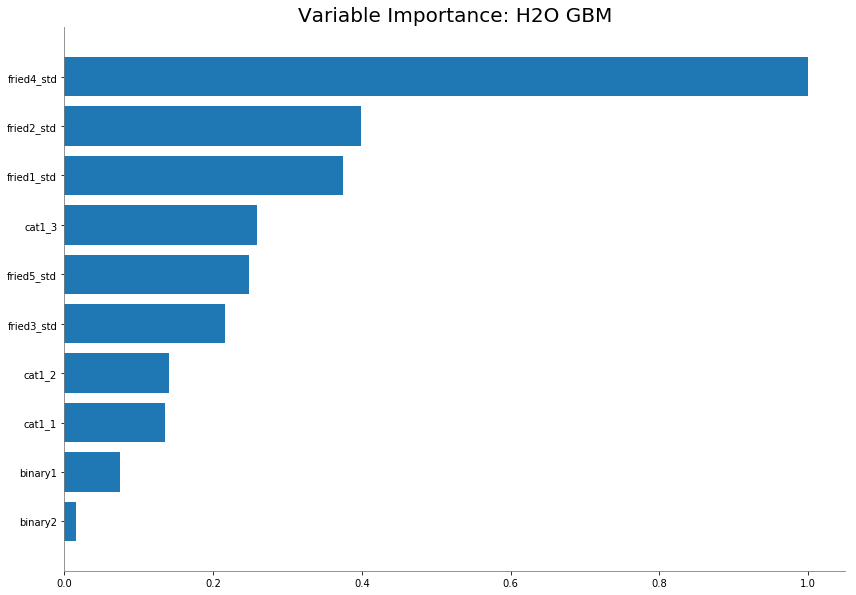

In [31]:
# MGBM var importance
mgbm_default.varimp_plot()

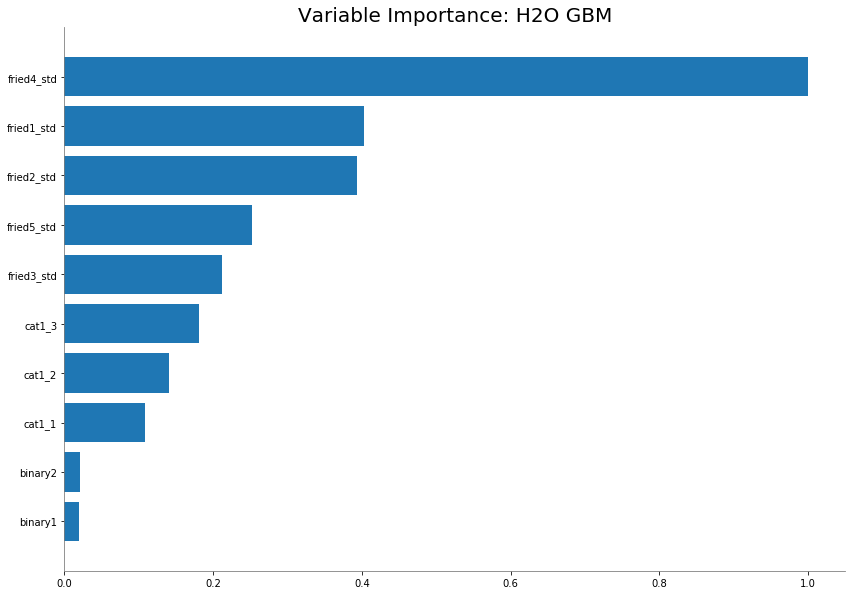

In [32]:
# GBM var importance
gbm_default.varimp_plot()

# Shapley Importance for MGBM and GBM

## Shapley for MGBM

In [33]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.139411,-0.0368788,0.00165618,-0.0493235,0.111618,0.345516,0.00321922,0.507035,0.371477,-0.0341987,-1.04129,-0.109423,0.0137855
0.139677,-0.0417522,0.00078471,-0.0490697,0.117955,0.395486,0.00195972,0.308024,0.40811,-0.286431,1.11756,0.226089,0.0137855
0.106764,-0.0255753,0.00605363,-0.0393678,0.132803,0.312171,0.0040498,0.0592149,0.351513,-0.171142,0.125656,-0.40919,0.0137855
0.10422,-0.0370929,0.00595198,-0.0385641,0.121914,0.327032,0.00378138,-0.281661,0.297889,0.0951625,-1.07661,-0.491532,0.0137855
0.139047,0.120378,-0.00200096,-0.0912422,-0.333385,-0.219852,0.00212869,0.439234,0.262776,-0.16783,-0.93965,0.129232,0.0137855


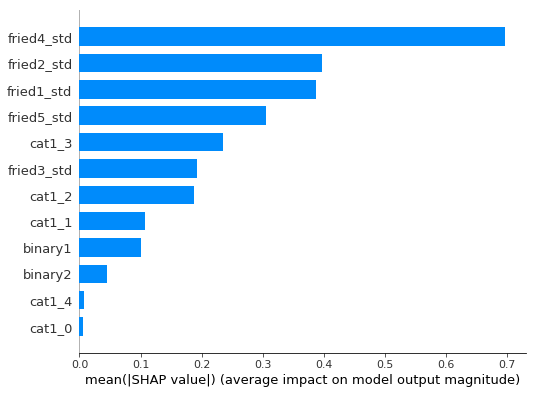

In [34]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [35]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.0527343,-0.0670214,0.0101309,-0.0615339,0.117444,0.337712,0.00885265,0.709877,0.536481,-0.120054,-1.22106,-0.0962571,-0.00572643
0.0872525,-0.0364304,0.0438712,-0.0427076,0.156726,0.285075,0.00641298,0.361486,0.638415,-0.282316,1.23481,0.226708,-0.00572643
0.131884,-0.0645856,0.0198053,-0.049758,0.148595,0.396253,0.00725404,0.12417,0.539094,-0.295861,0.150537,-0.538994,-0.00572643
0.0732837,-0.0859487,0.00756486,-0.0454264,0.145341,0.267708,0.00969975,-0.417023,0.271413,0.0779759,-1.25226,-0.491364,-0.00572643
0.0671733,0.122288,0.00713704,-0.113781,-0.460111,-0.245059,0.00449064,0.689753,0.344968,-0.256335,-1.0817,0.115029,-0.00572643


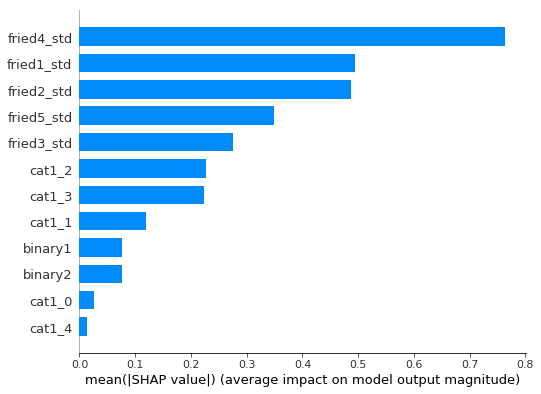

In [36]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

# Build Default XGBoost with Monotonic Constraints

In [37]:
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Model Summary

In [38]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575925687897_21053


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15913512633401317
RMSE: 0.3989174430054584
LogLoss: 0.48126013520306987
Mean Per-Class Error: 0.2357347908917966
AUC: 0.8483709068718327
pr_auc: 0.8454506349740204
Gini: 0.6967418137436654

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40194141993728966: 


,,0,1,Error,Rate
0,0,26091.0,13961.0,0.3486,(13961.0/40052.0)
1,1,5761.0,34187.0,0.1442,(5761.0/39948.0)
2,Total,31852.0,48148.0,0.2465,(19722.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.401941,0.776131,240.0
1,max f2,0.186841,0.862653,324.0
2,max f0point5,0.618995,0.777115,150.0
3,max accuracy,0.509991,0.764275,195.0
4,max precision,0.997668,1.000000,0.0
5,max recall,0.005247,1.000000,399.0
6,max specificity,0.997668,1.000000,0.0
7,max absolute_mcc,0.509991,0.528596,195.0
8,max min_per_class_accuracy,0.501396,0.763158,198.0
9,max mean_per_class_accuracy,0.509991,0.764265,195.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 50.22 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010000,0.986606,1.995094,1.995094,0.996250,0.992257,0.996250,0.992257,0.019951,0.019951,99.509362,99.509362
1,,2,0.020000,0.977096,1.977571,1.986332,0.987500,0.981829,0.991875,0.987043,0.019776,0.039727,97.757084,98.633223
2,,3,0.030000,0.967130,1.972564,1.981743,0.985000,0.972091,0.989583,0.982059,0.019726,0.059452,97.256433,98.174293
3,,4,0.040000,0.958207,1.947532,1.973190,0.972500,0.962794,0.985313,0.977243,0.019475,0.078928,94.753179,97.319015
4,,5,0.050000,0.948710,1.930009,1.964554,0.963750,0.953332,0.981000,0.972461,0.019300,0.098228,93.000901,96.455392
5,,6,0.100000,0.903305,1.881947,1.923250,0.939750,0.925979,0.960375,0.949220,0.094097,0.192325,88.194653,92.325023
6,,7,0.150000,0.855506,1.796836,1.881112,0.897250,0.879389,0.939333,0.925943,0.089842,0.282167,79.683589,88.111211
7,,8,0.200000,0.805474,1.690698,1.833509,0.844250,0.830115,0.915562,0.901986,0.084535,0.366702,69.069791,83.350856
8,,9,0.300000,0.703765,1.523981,1.730333,0.761000,0.755338,0.864042,0.853103,0.152398,0.519100,52.398118,73.033277
9,,10,0.400000,0.600526,1.334985,1.631496,0.666625,0.651433,0.814688,0.802686,0.133499,0.652598,33.498548,63.149594




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.16569965909552523
RMSE: 0.4070622300036264
LogLoss: 0.4990587825444071
Mean Per-Class Error: 0.24611365093207005
AUC: 0.8352383149902524
pr_auc: 0.8305469558609206
Gini: 0.6704766299805047

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4023805643440387: 


,,0,1,Error,Rate
0,0,25904.0,14148.0,0.3532,(14148.0/40052.0)
1,1,6343.0,33605.0,0.1588,(6343.0/39948.0)
2,Total,32247.0,47753.0,0.2561,(20491.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.402381,0.766354,240.0
1,max f2,0.163153,0.857203,335.0
2,max f0point5,0.586945,0.764556,168.0
3,max accuracy,0.490630,0.753875,205.0
4,max precision,0.991758,0.995238,2.0
5,max recall,0.004608,1.000000,399.0
6,max specificity,0.997325,0.999975,0.0
7,max absolute_mcc,0.490630,0.507844,205.0
8,max min_per_class_accuracy,0.498022,0.752547,202.0
9,max mean_per_class_accuracy,0.490630,0.753886,205.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.79 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.985475,1.980074,1.980074,0.988750,0.991572,0.988750,0.991572,0.019801,0.019801,98.007410,98.007410
1,,2,0.02,0.974902,1.960048,1.970061,0.978750,0.980142,0.983750,0.985857,0.019600,0.039401,96.004806,97.006108
2,,3,0.03,0.964485,1.947532,1.962551,0.972500,0.969442,0.980000,0.980385,0.019475,0.058877,94.753179,96.255132
3,,4,0.04,0.954030,1.907480,1.948783,0.952500,0.959220,0.973125,0.975094,0.019075,0.077951,90.747972,94.878342
4,,5,0.05,0.945150,1.914989,1.942025,0.956250,0.949590,0.969750,0.969993,0.019150,0.097101,91.498949,94.202463
5,,6,0.10,0.897644,1.853910,1.897967,0.925750,0.921648,0.947750,0.945821,0.092696,0.189797,85.391008,89.796736
6,,7,0.15,0.849834,1.763793,1.853243,0.880750,0.873716,0.925417,0.921786,0.088190,0.277986,76.379293,85.324255
7,,8,0.20,0.800774,1.661160,1.805222,0.829500,0.824993,0.901438,0.897588,0.083058,0.361044,66.115951,80.522179
8,,9,0.30,0.698872,1.494192,1.701545,0.746125,0.750019,0.849667,0.848398,0.149419,0.510464,49.419245,70.154534
9,,10,0.40,0.596664,1.321218,1.606463,0.659750,0.647100,0.802188,0.798074,0.132122,0.642585,32.121758,60.646340




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7432271,0.0039419387,0.74171853,0.74074537,0.7501889,0.742389,0.7410937
1,auc,0.8353051,0.0032180457,0.83766246,0.83500475,0.8394058,0.8322071,0.8322453
2,err,0.25677288,0.0039419387,0.25828144,0.25925466,0.24981108,0.25761095,0.25890633
3,err_count,4108.6,82.730286,4148.0,4167.0,3967.0,4104.0,4157.0
4,f0point5,0.7261513,0.0057026483,0.72681785,0.72085434,0.7354315,0.72535074,0.72230214
5,f1,0.76694053,0.0052268747,0.77146006,0.7643233,0.7734567,0.76416504,0.7612977
6,f2,0.81261146,0.006822439,0.82194513,0.8133712,0.81562847,0.8073682,0.80474424
7,lift_top_group,1.9852228,0.01382254,1.9715197,1.9835894,1.9722692,1.997657,2.0010786
8,logloss,0.49905282,0.0043621785,0.49554172,0.5002375,0.49347532,0.5031436,0.502866
9,max_per_class_error,0.3596206,0.013039381,0.37945414,0.36596477,0.34750602,0.35323507,0.35194293



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 14:52:48,22.415 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-09 14:52:48,22.489 sec,1.0,0.472084,0.638158,0.761232,0.654082,1.841758,0.339788
2,,2019-12-09 14:52:48,22.542 sec,2.0,0.455777,0.605678,0.777584,0.752130,1.955696,0.311425
3,,2019-12-09 14:52:48,22.587 sec,3.0,0.447330,0.588072,0.784472,0.764742,1.977602,0.312038
4,,2019-12-09 14:52:48,22.638 sec,4.0,0.440154,0.572680,0.790941,0.771151,1.977602,0.307975
5,,2019-12-09 14:52:48,22.698 sec,5.0,0.435436,0.562182,0.795952,0.794400,1.982000,0.301638
6,,2019-12-09 14:52:49,22.778 sec,6.0,0.431700,0.553953,0.801148,0.799983,1.988484,0.295575
7,,2019-12-09 14:52:49,22.890 sec,7.0,0.428717,0.546743,0.803838,0.803589,1.990087,0.293500
8,,2019-12-09 14:52:49,22.959 sec,8.0,0.425928,0.540855,0.809003,0.808443,1.987714,0.291262
9,,2019-12-09 14:52:49,23.031 sec,9.0,0.424297,0.536856,0.810415,0.810205,1.997597,0.290237



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4_std,22255.697266,1.000000,0.357478
1,fried2_std,8985.703125,0.403748,0.144331
2,fried1_std,8812.653320,0.395973,0.141551
3,fried5_std,5832.357422,0.262061,0.093681
4,fried3_std,4414.045898,0.198333,0.070900
5,cat1_3,3977.504150,0.178718,0.063888
6,cat1_2,3758.582031,0.168882,0.060371
7,cat1_1,2498.366455,0.112257,0.040130
8,binary2,569.786438,0.025602,0.009152
9,binary1,414.350830,0.018618,0.006655


In [39]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8371027847037061


In [40]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.8352383149902524


# Build Default XGBoost with NO Monotonic Constraints

In [41]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


# Model Summary

In [42]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575925687897_21428


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14648536785158126
RMSE: 0.3827340693635481
LogLoss: 0.448915519299856
Mean Per-Class Error: 0.21345703074238198
AUC: 0.8710346889236242
pr_auc: 0.8680229267458869
Gini: 0.7420693778472485

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3950963728869988: 


,,0,1,Error,Rate
0,0,27532.0,12520.0,0.3126,(12520.0/40052.0)
1,1,5377.0,34571.0,0.1346,(5377.0/39948.0)
2,Total,32909.0,47091.0,0.2237,(17897.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.395096,0.794380,238.0
1,max f2,0.204418,0.870801,313.0
2,max f0point5,0.625575,0.800982,152.0
3,max accuracy,0.485014,0.786525,205.0
4,max precision,0.995358,1.000000,0.0
5,max recall,0.006028,1.000000,399.0
6,max specificity,0.995358,1.000000,0.0
7,max absolute_mcc,0.485014,0.573293,205.0
8,max min_per_class_accuracy,0.502556,0.785671,199.0
9,max mean_per_class_accuracy,0.485014,0.786543,205.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.94 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.984211,1.997597,1.997597,0.997500,0.989523,0.997500,0.989523,0.019976,0.019976,99.759688,99.759688
1,,2,0.02,0.975783,1.995094,1.996345,0.996250,0.979940,0.996875,0.984732,0.019951,0.039927,99.509362,99.634525
2,,3,0.03,0.968164,1.972564,1.988418,0.985000,0.971925,0.992917,0.980463,0.019726,0.059653,97.256433,98.841828
3,,4,0.04,0.960714,1.965055,1.982577,0.981250,0.964494,0.990000,0.976471,0.019651,0.079303,96.505457,98.257735
4,,5,0.05,0.953501,1.950035,1.976069,0.973750,0.957195,0.986750,0.972616,0.019500,0.098803,95.003505,97.606889
5,,6,0.10,0.917742,1.920497,1.948283,0.959000,0.935862,0.972875,0.954239,0.096025,0.194828,92.049665,94.828277
6,,7,0.15,0.877678,1.841894,1.912820,0.919750,0.898029,0.955167,0.935502,0.092095,0.286923,84.189446,91.282000
7,,8,0.20,0.833667,1.730249,1.867177,0.864000,0.856105,0.932375,0.915653,0.086512,0.373435,73.024932,86.717733
8,,9,0.30,0.731845,1.608841,1.781065,0.803375,0.783716,0.889375,0.871674,0.160884,0.534320,60.884149,78.106539
9,,10,0.40,0.619976,1.390057,1.683313,0.694125,0.677513,0.840562,0.823134,0.139006,0.673325,39.005707,68.331331




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.1629802845609746
RMSE: 0.4037081675678294
LogLoss: 0.4931123399461398
Mean Per-Class Error: 0.24063645292560543
AUC: 0.8407519858708562
pr_auc: 0.836598322482646
Gini: 0.6815039717417124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39236368304990193: 


,,0,1,Error,Rate
0,0,26463.0,13589.0,0.3393,(13589.0/40052.0)
1,1,6320.0,33628.0,0.1582,(6320.0/39948.0)
2,Total,32783.0,47217.0,0.2489,(19909.0/80000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.392364,0.771594,242.0
1,max f2,0.149849,0.858760,336.0
2,max f0point5,0.613518,0.770985,158.0
3,max accuracy,0.525795,0.759387,191.0
4,max precision,0.993492,0.994624,1.0
5,max recall,0.005977,1.000000,399.0
6,max specificity,0.995955,0.999975,0.0
7,max absolute_mcc,0.525795,0.519092,191.0
8,max min_per_class_accuracy,0.503120,0.759038,200.0
9,max mean_per_class_accuracy,0.525795,0.759364,191.0



Gains/Lift Table: Avg response rate: 49.94 %, avg score: 49.90 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.01,0.983712,1.977571,1.977571,0.987500,0.989480,0.987500,0.989480,0.019776,0.019776,97.757084,97.757084
1,,2,0.02,0.975116,1.962551,1.970061,0.980000,0.979375,0.983750,0.984427,0.019626,0.039401,96.255132,97.006108
2,,3,0.03,0.967581,1.935016,1.958379,0.966250,0.971288,0.977917,0.980048,0.019350,0.058751,93.501552,95.837923
3,,4,0.04,0.959868,1.925003,1.950035,0.961250,0.963761,0.973750,0.975976,0.019250,0.078001,92.500250,95.003505
4,,5,0.05,0.952764,1.884950,1.937018,0.941250,0.956411,0.967250,0.972063,0.018850,0.096851,88.495044,93.701812
5,,6,0.10,0.915717,1.859417,1.898218,0.928500,0.934489,0.947875,0.953276,0.092971,0.189822,85.941724,89.821768
6,,7,0.15,0.875195,1.762792,1.853076,0.880250,0.895766,0.925333,0.934106,0.088140,0.277961,76.279163,85.307567
7,,8,0.20,0.831890,1.684690,1.810979,0.841250,0.853398,0.904312,0.913929,0.084235,0.362196,68.469010,81.097927
8,,9,0.30,0.733008,1.518724,1.713561,0.758375,0.783112,0.855667,0.870324,0.151872,0.514068,51.872434,71.356096
9,,10,0.40,0.621841,1.340493,1.620294,0.669375,0.678781,0.809094,0.822438,0.134049,0.648118,34.049264,62.029388




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74971205,0.00680237,0.75541717,0.74877125,0.7570529,0.7471596,0.74015945
1,auc,0.8407774,0.003329221,0.84317255,0.8388307,0.8453881,0.8388612,0.83763444
2,err,0.25028792,0.00680237,0.24458282,0.25122878,0.2429471,0.25284037,0.25984055
3,err_count,4004.8,119.420265,3928.0,4038.0,3858.0,4028.0,4172.0
4,f0point5,0.7324264,0.010749677,0.7431847,0.73070335,0.7427931,0.72761554,0.71783525
5,f1,0.7720716,0.0054079215,0.77739996,0.7672891,0.77789295,0.7712923,0.76648384
6,f2,0.8163754,0.005662376,0.8149178,0.8077315,0.8164745,0.8205475,0.82220566
7,lift_top_group,1.980191,0.011402482,1.9715197,1.9961438,1.9722692,1.9725292,1.9884932
8,logloss,0.49310178,0.0049548433,0.48924837,0.4963363,0.48638567,0.4961044,0.49743408
9,max_per_class_error,0.34906375,0.02132094,0.3337124,0.3377663,0.33164108,0.3616038,0.38059518



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-09 14:53:16,22.455 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.500650
1,,2019-12-09 14:53:16,22.533 sec,1.0,0.466319,0.627212,0.792318,0.675645,1.841758,0.307200
2,,2019-12-09 14:53:16,22.612 sec,2.0,0.446452,0.588370,0.809973,0.769759,1.940849,0.278263
3,,2019-12-09 14:53:16,22.673 sec,3.0,0.434154,0.563225,0.816696,0.798082,1.959203,0.280275
4,,2019-12-09 14:53:16,22.761 sec,4.0,0.424580,0.543301,0.826051,0.818627,1.978814,0.263412
5,,2019-12-09 14:53:16,22.846 sec,5.0,0.417830,0.528749,0.832081,0.826110,1.980297,0.259425
6,,2019-12-09 14:53:16,22.919 sec,6.0,0.413098,0.518179,0.836318,0.830825,1.992811,0.258113
7,,2019-12-09 14:53:16,22.992 sec,7.0,0.409449,0.510032,0.839986,0.833981,1.989929,0.252787
8,,2019-12-09 14:53:16,23.065 sec,8.0,0.406315,0.503083,0.843829,0.840532,1.992603,0.248388
9,,2019-12-09 14:53:16,23.139 sec,9.0,0.403929,0.497488,0.845883,0.842490,1.995131,0.245750



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,fried4_std,24535.261719,1.000000,0.321963
1,fried1_std,12130.483398,0.494410,0.159182
2,fried2_std,11578.386719,0.471908,0.151937
3,fried5_std,7736.077637,0.315304,0.101516
4,fried3_std,7674.542969,0.312796,0.100709
5,cat1_3,4353.974609,0.177458,0.057135
6,cat1_2,3462.320068,0.141116,0.045434
7,cat1_1,2935.788330,0.119656,0.038525
8,binary2,705.452881,0.028753,0.009257
9,binary1,701.573242,0.028594,0.009206


In [43]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8435709706349404


In [44]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8407519858708562


# Variable Importance of MXGB and XGB

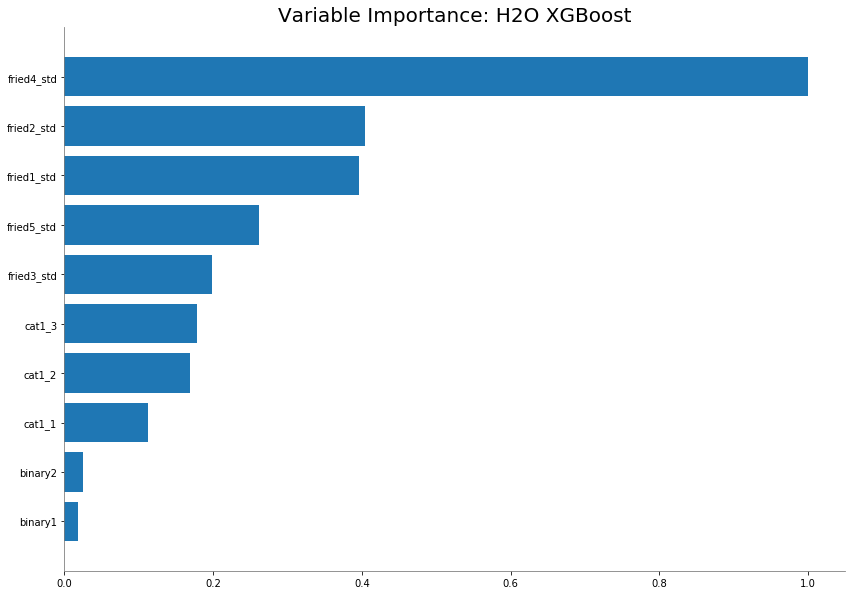

In [45]:
# MXGB var importance
mxgb_default.varimp_plot()

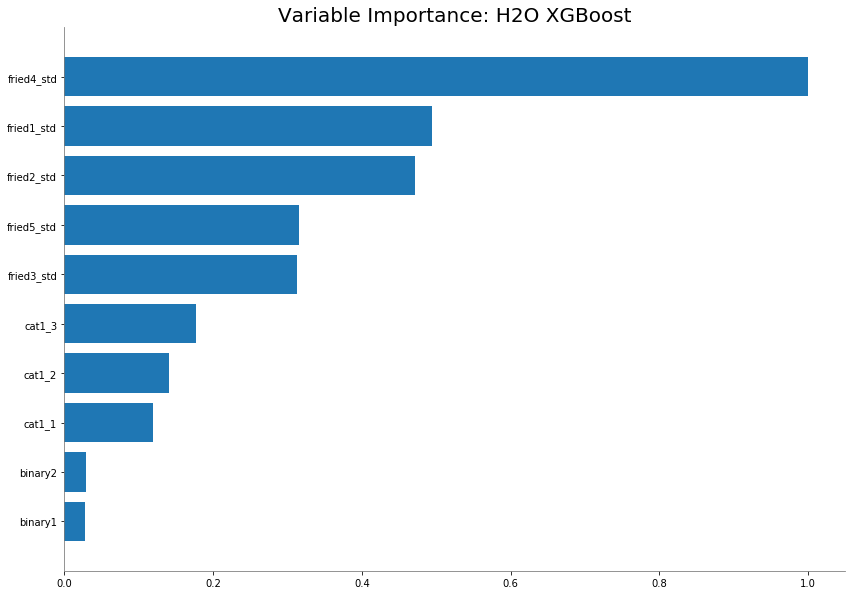

In [46]:
# XGB var importance
xgb_default.varimp_plot()

# Shapley Importance for MXGB and XGB

## Shapey for MXGB

In [47]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.0357503,-0.0983639,-0.000629522,-0.0373947,0.0154528,0.141915,0.0143986,0.530418,0.223348,0.0188912,-0.793636,0.0972007,0
0.0967465,-0.0763447,0.075102,-0.0405861,0.100714,0.156685,0.0147062,0.938813,0.906466,-0.045348,1.28977,0.754709,0
0.0632593,-0.0561061,0.00894032,-0.0264126,0.0449637,0.10886,0.00844674,0.0757368,0.337175,-0.322065,0.0790721,-0.202854,0
0.0902669,-0.0959614,0.01325,-0.0239895,0.056029,0.13471,0.00679465,-0.416917,-0.0220663,-0.245082,-0.999394,-0.576305,0
0.0521786,0.127951,0.00324306,-0.0627228,-0.31552,-0.072744,0.0102796,0.450062,-0.127848,-0.268919,-0.740481,0.102065,0


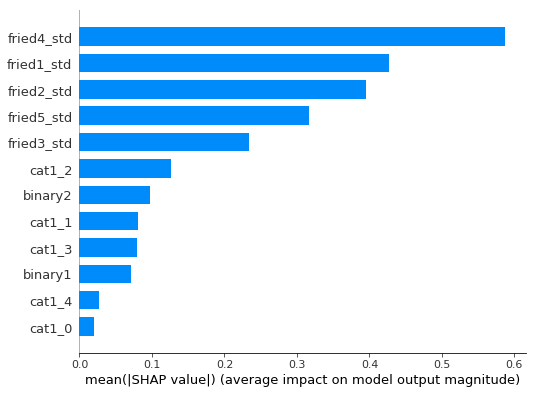

In [48]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [49]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.0453608,-0.135512,-0.0192167,-0.0342686,0.0935014,0.105273,0.0166515,0.532818,0.253794,-0.107243,-0.638405,0.0110547,0
0.082018,-0.067061,0.000693431,-0.029447,0.124641,0.206754,0.0193115,0.672766,0.773941,0.0763451,1.22688,0.646919,0
0.146734,-0.0692898,-0.00710032,-0.0194576,0.131736,0.154296,0.0164893,-0.118567,0.37982,-0.359659,0.151696,-0.187901,0
0.0935661,-0.0866297,0.00901421,-0.0168981,0.129631,0.117352,0.0138079,-0.676704,-0.00225098,-0.16879,-0.784864,-0.390419,0
0.068331,0.0978183,-0.00698305,-0.0861014,-0.32909,-0.113199,0.013832,0.486711,-0.11451,-0.337729,-0.777601,0.156725,0


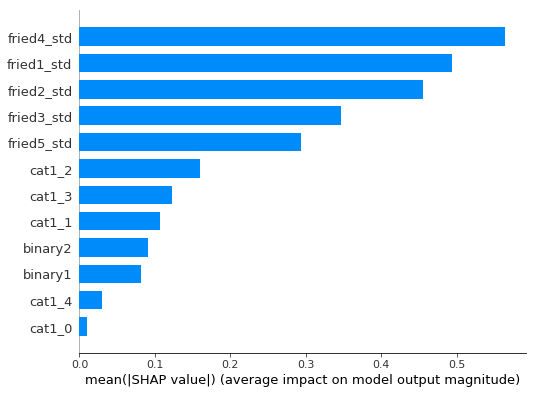

In [50]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

# MGBM Grid Search (Constrained)

In [51]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

In [52]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [53]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [54]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1      0.7000000000000001       0.09        10                 0.5   
2                     0.8       0.09        10  0.7000000000000001   
3                     1.0       0.09         5                 0.5   
4                     1.0       0.09        10                 0.9   
5     0.30000000000000004        0.1         6  0.7000000000000001   
6      0.7000000000000001       0.08         9  0.6000000000000001   
7                     0.9       0.08         6                 0.8   
8     0.30000000000000004       0.08         6                 0.8   
9                     0.2       0.09         6                 1.0   
10     0.7000000000000001        0.1         3  0.7000000000000001   
11                    0.4       0.08         5                 0.8   
12                    0.4       0.07         5                 0.5   
13                  

In [55]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.8416868424507638

# Shapley Importance

In [56]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.156505,-0.0527525,0.015272,-0.0372803,0.114948,0.209152,0.00975227,0.566833,0.438278,0.0163506,-1.00812,-0.105594,0.0129074
0.212651,-0.0510355,0.021038,-0.0272618,0.161992,0.410334,0.00840651,0.333398,0.469605,-0.246356,1.22182,0.250856,0.0129074
0.156272,-0.0406393,0.0149368,-0.0259109,0.147559,0.259963,0.00849927,0.06469,0.376811,-0.180763,0.148234,-0.44292,0.0129074
0.113891,-0.037288,0.0246283,-0.0189919,0.120788,0.180305,0.0114431,-0.338792,0.281455,0.0996011,-1.03171,-0.466588,0.0129074
0.157667,0.18137,0.00362476,-0.0577429,-0.417937,-0.194304,0.0052738,0.467043,0.287324,-0.17992,-0.878779,0.0701853,0.0129074


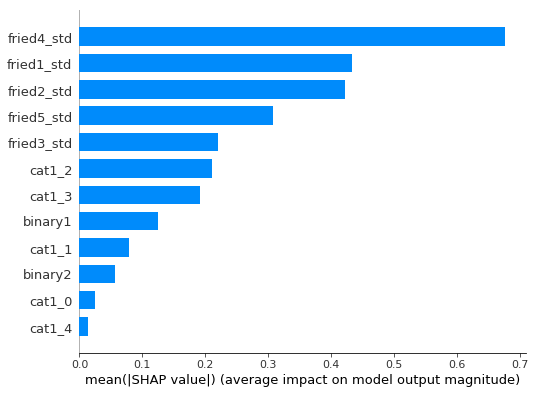

In [57]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [58]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MGBM_BEST_GRID_v2_SIMULATED_1575932311.860524/mgbm_grid2_simulated_model_20


# GBM Grid Search (Unconstrained)

In [59]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [60]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [61]:
print(gbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1                     1.0       0.09         5                 0.5   
2                     0.9       0.08         6                 0.8   
3     0.30000000000000004       0.08         6                 0.8   
4                     0.5        0.1         8  0.7000000000000001   
5                     0.2       0.09         6                 1.0   
6                     0.4       0.04         9                 0.5   
7                     0.4       0.08         5                 0.8   
8                     0.9       0.06         6                 0.9   
9      0.7000000000000001       0.08         9  0.6000000000000001   
10                    0.2       0.06         7                 0.8   
11    0.30000000000000004       0.04        10                 0.9   
12                    0.4       0.07         5                 0.5   
13                  

In [62]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.84723972183513

# Shapley Importance

In [63]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.133085,-0.0588821,0.0264045,-0.0390189,0.158386,0.194619,0.0266142,0.645756,0.410199,-0.0477406,-1.17478,-0.124538,-0.00362614
0.160709,-0.0325426,0.0292459,-0.0279625,0.220893,0.255453,0.0286658,0.423004,0.618454,-0.277557,1.29376,0.242068,-0.00362614
0.181586,-0.0775272,0.0338387,-0.0499976,0.197505,0.282562,0.0173494,0.0944192,0.482573,-0.336524,0.192706,-0.548212,-0.00362614
0.205384,-0.0796521,0.0282729,-0.0419234,0.170284,0.226346,0.0211825,-0.420502,0.252095,0.225997,-1.19181,-0.524431,-0.00362614
0.135189,0.198471,0.013664,-0.0681182,-0.491704,-0.162228,0.0113478,0.632363,0.287332,-0.31311,-1.02721,0.157091,-0.00362614


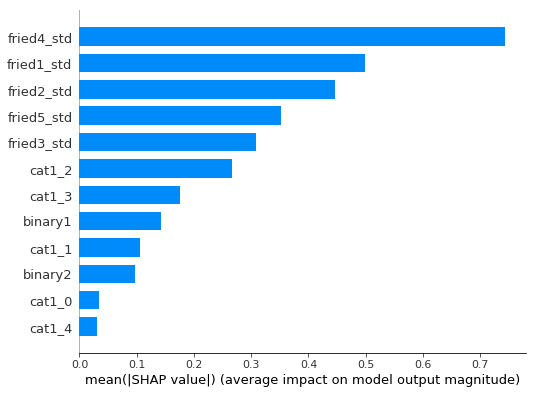

In [64]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [65]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/GBM_BEST_GRID_v2_SIMULATED_1575932627.142728/gbm_grid2_simulated_model_12


# Repeat Previous but with XGBoost

In [66]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [67]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [68]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0     0.30000000000000004        0.1         6  0.7000000000000001   
1     0.30000000000000004       0.08         6                 0.8   
2                     0.2       0.09         6                 1.0   
3      0.7000000000000001        0.1         3  0.7000000000000001   
4                     0.5        0.1         8  0.7000000000000001   
5                     0.4       0.08         5                 0.8   
6                     0.4       0.07         5                 0.5   
7                     0.2        0.1         3                 0.8   
8      0.7000000000000001       0.09        10                 0.5   
9                     0.2       0.06         7                 0.8   
10                    0.8       0.09        10  0.7000000000000001   
11     0.7000000000000001       0.08         9  0.6000000000000001   
12                    1.0       0.09         5                 0.5   
13                  

In [69]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.8439947413511129

# Shapley Importance

In [70]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.0768498,-0.0844557,0.00891047,-0.0715005,0.0958408,0.110494,0.00778856,0.552167,0.381929,0.0538805,-0.565375,-0.099807,0
0.165244,-0.0333058,0.0538824,-0.043596,0.174979,0.180708,0.0246001,0.531135,0.773326,0.0161773,1.28434,0.277507,0
0.0849781,-0.0539936,0.0191918,-0.0570027,0.0827094,0.16816,0.00566684,0.0352471,0.438309,-0.165428,0.116828,-0.376214,0
0.0869549,-0.144877,0.00762374,-0.0469166,0.0460658,0.135199,0.00398266,-0.279413,0.235873,0.000864065,-0.786973,-0.484946,0
0.095028,0.170044,0.00743054,-0.111269,-0.237851,-0.0836395,0.0238738,0.38272,0.166465,-0.209239,-0.582295,0.00557349,0


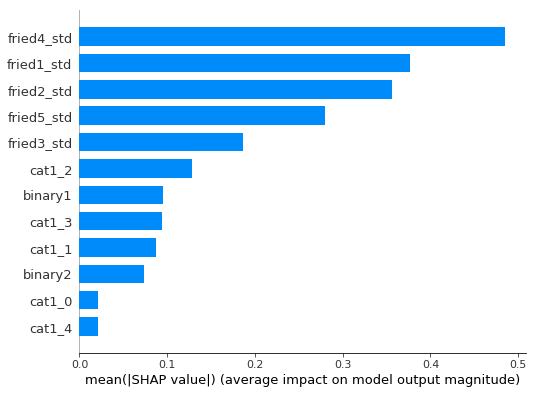

In [71]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [72]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MXGB_BEST_GRID_v2_SIMULATED_1575933183.1382315/mxgb_grid2_simulated_model_12


In [73]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2_simulated',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [74]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [75]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     1.0       0.09         5                 0.5   
1     0.30000000000000004        0.1         6  0.7000000000000001   
2     0.30000000000000004       0.08         6                 0.8   
3                     0.4       0.08         5                 0.8   
4                     0.2       0.09         6                 1.0   
5                     0.4       0.07         5                 0.5   
6                     0.9       0.08         6                 0.8   
7                     0.9       0.06         6                 0.9   
8                     0.4       0.04         9                 0.5   
9                     0.2       0.06         7                 0.8   
10     0.6000000000000001       0.04         7                 0.8   
11    0.30000000000000004       0.04        10                 0.9   
12     0.7000000000000001        0.1         3  0.7000000000000001   
13     0.70000000000

In [76]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.8480181531506789

# Shapley Importance

In [77]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



binary1,binary2,cat1_0,cat1_1,cat1_2,cat1_3,cat1_4,fried1_std,fried2_std,fried3_std,fried4_std,fried5_std,BiasTerm
0.0726084,-0.0462837,0.0127993,-0.0354193,0.0877412,0.171915,0.0453037,0.479157,0.376785,-0.140224,-0.684728,-0.0344873,0
0.075955,-0.0348454,0.0876834,-0.0407816,0.120883,0.144278,0.0524293,0.545576,1.12562,-0.149918,1.15928,0.347839,0
0.107733,-0.0554432,0.0160005,-0.0377777,0.110197,0.193069,0.0446941,0.0292935,0.567225,-0.400681,0.149728,-0.379686,0
0.100423,-0.122563,0.0120927,-0.0340191,0.108469,0.185055,0.0132076,-0.562989,0.204808,-0.118429,-0.894232,-0.418429,0
0.0340122,0.127673,0.0102389,-0.0855176,-0.322007,-0.118474,0.0243197,0.369466,0.079757,-0.349636,-0.69098,0.00184935,0


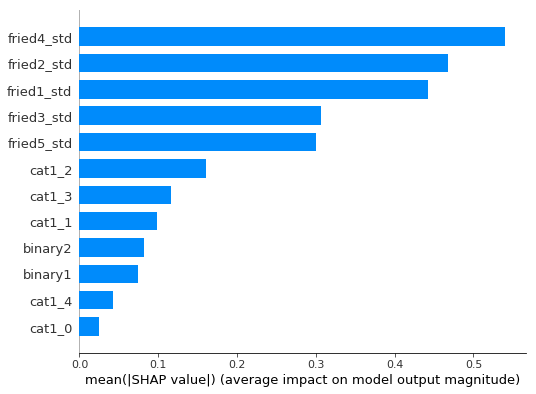

In [78]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [79]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_SIMULATED_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/XGB_BEST_GRID_v2_SIMULATED_1575934130.1232975/xgb_grid2_simulated_model_24
